## <font color='darkblue'>Section4: Random Forest</font>
This course is from Udemy <b>["Ensemble Machine Learning in Python"](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/)</b>. This section is coming from [here](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6241010#questions).

## <font color='darkBlue'>Random Forest Algorithm</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6241010#questions))
* Builds on earlier concepts
* Recall: If we have B [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) (Independent and identical distributed) random variables, variance of the sum/sample mean is:
![IID variance](images/S4_1-1.PNG)
<br/>
* If we have B ID (Only identically distributed, not independent), then variance of the sum is:
![IID variance](images/S4_1-2.PNG)
<br/>

### <font color='darkgreen'>Random Forest</font>
* Random forest tries to reduce this correlation
* i.e. build a set of trees decorrelated from each other
* Recall bagging: by having many trees of arbitrary depth, we can ensure they overfit (<font color='brown'>0 bias</font>) to their own training samples (<font color='brown'>and thus will probably be very different from each other</font>)
* If there anything else we can do to ensure decorrelation (<font color='brown'>other than just letting each tree overfit</font>)?
* We can achieve low bias easily with trees simply by adding more nodes.
* Suppose each tree in ensemble has low bias
* Each tree has same expected value then expected value of sum of trees also have same expected value
* So the ensemble also have low bias (<font color='brown'>Later we will see how we can combine trees with high bias</font>)
* How does random forest decorrelate the trees?
    * Before: we randomly chose which samples to train on
    * Now: we can also choose which features to train on!
* How many do we choose? (d << D) Below is the recommendations by inventors:
![IID variance](images/S4_1-3.PNG)
<br/>
* Classification: Can be set as low as 1
* Regression: Can be set as low as 5
* BEST: what works for your specific dataset

### <font color='darkgreen'>Random Forest Training</font>
The pseudo code of Random Forest Training algorithm as below:
```python
for b=1..B:
    Xb, Yb = sample_with_replacement(X, Y)
    model = DecisionTree()
    while not at terminal node and not reached max_depth:
        select d features randomly
        choose best split from the d features (i.e. max information gain)
        add split to model
    models.append(model)
```
* Just like bagging, we need to get bootstrap sample
* Sometimes RF is called "feature bagging"
* These are NOT ensembles of vanilla decision trees. Why?
* <b>We've changed how they make splits.</b>
* So you can't build a random forest using built-in decision tree class
* We won't build random forest in this course
* But you already have all the skills you need, so give it a try.

### <font color='darkgreen'>Random Forest Prediction</font>
Same as bagging DT. Let's check the parameters of exist implementation in scikt-learn as <b>[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)</b>
* `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
* `n_estimators`: The number of trees in the forest. Default is 100
* `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
* `min_samples_split`: The minimum number of samples required to split an internal node. Default is 2
* `max_features`: The number of features to consider when looking for the best split.
* ...

### <font color='darkgreen'>What If</font>
* What if many features are just noise?
* What if RF choose only noise to split on?
* If we have 3 relevant + 100 irrelevant inputs, probability of choosing a relevant feature for d = floor(sqrt(103)) = 10 is:
![IID variance](images/S4_1-4.PNG)
<br/>
* If we have 6 relevant variables this would go up to 46%
* We will later learn a algorithm that doesn't have this problem

### <font color='darkgreen'>Advantages</font>
* Big advantage: Requires very little turning
* Can let all trees go to arbitrary depth without incurring much penalty
* Perform well and fast
* When people come to deep learning in search of an API, I just recommend random forest instead. Why? Neural networks have many more hyperparameters and are sensitive to those choices.

## <font color='darkblue'>Random Forest Regressor</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6241014#questions))
* We will apply to real data by using RF in this segment
* No more 2-D plots (e.g. "time series"), why?
    * You've already seen smoothing effect of ensembling
    * Only 1 input -> doesn't make sense for random forest
* Housing price dataset can be found [here](http://archive.ics.uci.edu/ml/machine-learning-databases/housing/) and download `housing.data`. Then put it under folder `datas`.
* The code below is originally from [`rf_regression.py`](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/supervised_class2/rf_regression.py)
* Try coding yourself first and we are going to use SKLearn <b>[RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)</b>
* You already know how to load in/preprocess data and perform cross validation
* All features are numerical except for one binary (already 0/1)
* No feature engineering or feature selection in this class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

NUMERICAL_COLS = [
  'crim', # numerical
  'zn', # numerical
  'nonretail', # numerical
  'nox', # numerical
  'rooms', # numerical
  'age', # numerical
  'dis', # numerical
  'rad', # numerical
  'tax', # numerical
  'ptratio', # numerical
  'b', # numerical
  'lstat', # numerical
]

NO_TRANSFORM = ['river']

Class <font color='blue'><b>DataTransformer</b></font> for data preprocessing:

In [2]:
# transforms data from dataframe to numerical matrix
# we want to use the scales found in training when transforming the test set
# so only call fit() once
# call transform() for any subsequent data
class DataTransformer:
    def fit(self, df):
        self.scalers = {}
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].values.reshape(-1, 1))
            self.scalers[col] = scaler

    def transform(self, df):
        N, _ = df.shape
        D = len(NUMERICAL_COLS) + len(NO_TRANSFORM)
        X = np.zeros((N, D))
        i = 0
        for col, scaler in self.scalers.items():
            X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
            i += 1
        for col in NO_TRANSFORM:
            X[:,i] = df[col]
            i += 1
        return X

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

Then we define a method to retrieve data:

In [3]:
def get_data():
    df = pd.read_csv('datas/housing.data', header=None, delim_whitespace=True)
    df.columns = [
        'crim', # numerical
        'zn', # numerical
        'nonretail', # numerical
        'river', # binary
        'nox', # numerical
        'rooms', # numerical
        'age', # numerical
        'dis', # numerical
        'rad', # numerical
        'tax', # numerical
        'ptratio', # numerical
        'b', # numerical
        'lstat', # numerical
        'medv', # numerical -- this is the target
    ]

    # transform the data
    transformer = DataTransformer()

    # shuffle the data
    N = len(df)
    train_idx = np.random.choice(N, size=int(0.7*N), replace=False)
    test_idx = [i for i in range(N) if i not in train_idx]
    df_train = df.loc[train_idx]
    df_test = df.loc[test_idx]

    Xtrain = transformer.fit_transform(df_train)
    Ytrain = np.log(df_train['medv'].values)
    Xtest = transformer.transform(df_test)
    Ytest = np.log(df_test['medv'].values)
    return Xtrain, Ytrain, Xtest, Ytest

Now we are ready to train the model and show how it performs:

ymin=2.0; ymax=4.0


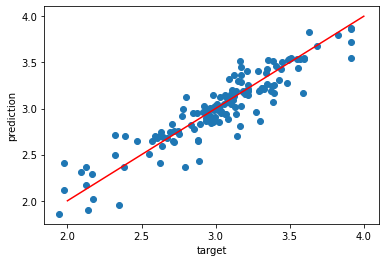

In [4]:
Xtrain, Ytrain, Xtest, Ytest = get_data()
model = RandomForestRegressor(n_estimators=100) # try 10, 20, 50, 100, 200
model.fit(Xtrain, Ytrain)
predictions = model.predict(Xtest)

# plot predictions vs targets
plt.scatter(Ytest, predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(Ytest), min(predictions) ) )
ymax = np.ceil( max( max(Ytest), max(predictions) ) )
print(f"ymin={ymin}; ymax={ymax}")
r = range(int(ymin), int(ymax) + 1)
plt.plot(r, r, color='r')  # prediction=target line
plt.show()

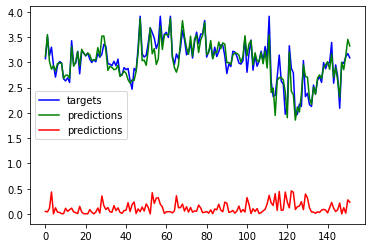

In [5]:
diff = np.absolute((Ytest - predictions))
plt.plot(Ytest, label='targets', color='blue')
plt.plot(predictions, label='predictions', color='green')
plt.plot(diff, label='predictions', color='red')
plt.legend()
plt.show()

In [6]:
predictions.shape

(152,)

Let's use another model <b>[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)</b> as baseline to see the difference:

In [7]:
# do a quick baseline test
baseline = LinearRegression()
single_tree = DecisionTreeRegressor()
print("CV single tree:", cross_val_score(single_tree, Xtrain, Ytrain, cv=5).mean())
print("CV baseline:", cross_val_score(baseline, Xtrain, Ytrain, cv=5).mean())
print("CV forest:", cross_val_score(model, Xtrain, Ytrain, cv=5).mean())

# test score
single_tree.fit(Xtrain, Ytrain)
baseline.fit(Xtrain, Ytrain)
print("test score single tree:", single_tree.score(Xtest, Ytest))
print("test score baseline:", baseline.score(Xtest, Ytest))
print("test score forest:", model.score(Xtest, Ytest))

CV single tree: 0.6930658236505248
CV baseline: 0.7743228033215993
CV forest: 0.8438985872503226
test score single tree: 0.6795676611853222
test score baseline: 0.7269897431490951
test score forest: 0.8353387066970811


From the output of above, we can observe that the RF did perform well than the baseline.

## <font color='darkblue'>Random Forest Classifier</font>
Now let's see how to apply RF in classification problem. Code below is from [`rf_classification.py`](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/supervised_class2/rf_classification.py) and the date set (Mushroom) can be found [here](http://archive.ics.uci.edu/ml/datasets/Mushroom). Please download <font color='olive'>agaricus-lepiota.data</font> and save it into folder `datas`.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

NUMERICAL_COLS = ()
CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

Another data transformer:

In [9]:
class DataTransformer:
    def fit(self, df):
        self.labelEncoders = {}
        self.scalers = {}
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].reshape(-1, 1))
            self.scalers[col] = scaler

        for col in CATEGORICAL_COLS:
            encoder = LabelEncoder()
            # in case the train set does not have 'missing' value but test set does
            values = df[col].tolist()
            values.append('missing')
            encoder.fit(values)
            self.labelEncoders[col] = encoder

        # find dimensionality
        self.D = len(NUMERICAL_COLS)
        for col, encoder in self.labelEncoders.items():
            self.D += len(encoder.classes_)
            
        print(f"dimensionality: {self.D}")

    def transform(self, df):
        N, _ = df.shape
        X = np.zeros((N, self.D))
        i = 0
        for col, scaler in self.scalers.items():
            X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
            i += 1

        for col, encoder in self.labelEncoders.items():
            # print "transforming col:", col
            K = len(encoder.classes_)
            X[np.arange(N), encoder.transform(df[col]) + i] = 1
            i += K
        return X

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)


def replace_missing(df):
    # standard method of replacement for numerical columns is median
    for col in NUMERICAL_COLS:
        if np.any(df[col].isnull()):
            med = np.median(df[ col ][ df[col].notnull() ])
            df.loc[ df[col].isnull(), col ] = med

    # set a special value = 'missing'
    for col in CATEGORICAL_COLS:
        if np.any(df[col].isnull()):
            print(col)
            df.loc[ df[col].isnull(), col ] = 'missing'

Here we define a function to retrieve data:

In [10]:
def get_data():
    df = pd.read_csv('datas/agaricus-lepiota.data', header=None)

    # replace label column: e/p --> 0/1
    # e = edible = 0, p = poisonous = 1
    df[0] = df.apply(lambda row: 0 if row[0] == 'e' else 1, axis=1)

    # check if there is missing data
    replace_missing(df)

    # transform the data
    transformer = DataTransformer()

    X = transformer.fit_transform(df)
    Y = df[0].values
    return X, Y

Now let's train the model and see how it performs:

In [11]:
X, Y = get_data()

# do a quick baseline test
baseline = LogisticRegression()
print("CV baseline: {:.02f}".format(cross_val_score(baseline, X, Y, cv=8).mean()))

# single tree
tree = DecisionTreeClassifier()
print("CV one tree: {:.02f}".format(cross_val_score(tree, X, Y, cv=8).mean()))

model = RandomForestClassifier(n_estimators=50) # try 10, 20, 50, 100, 200
print("CV forest: {:.02f}".format(cross_val_score(model, X, Y, cv=8).mean()))

dimensionality: 139
CV baseline: 0.93
CV one tree: 0.94
CV forest: 0.93


## <font color='darkblue'>Random Forest vs Bagging Trees</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6241022#questions)) In this segment, we are going to compare the behaviors between RF and bagging trees. The code below is from [`rf_vs_bag.py`](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/supervised_class2/rf_vs_bag.py)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, RandomForestClassifier, BaggingClassifier
from util import BaggedTreeRegressor, BaggedTreeClassifier

# make simple regression data
N = 15
D = 100
X = (np.random.random((N, D)) - 0.5)*10
Y = X.sum(axis=1)**2 + 0.5*np.random.randn(N)
Ntrain = N//2
Xtrain = X[:Ntrain]
Ytrain = Y[:Ntrain]
Xtest = X[Ntrain:]
Ytest = Y[Ntrain:]

Now let's see how RF and bagging trees perform along the increase in number of trees:

In [16]:
from tqdm import tqdm

T = 300
test_error_rf = np.empty(T)
test_error_bag = np.empty(T)
for num_trees in tqdm(range(T)):
    if num_trees == 0:
        test_error_rf[num_trees] = None
        test_error_bag[num_trees] = None
    else:
        rf = RandomForestRegressor(n_estimators=num_trees)
        # rf = RandomForestClassifier(n_estimators=num_trees)
        rf.fit(Xtrain, Ytrain)
        test_error_rf[num_trees] = rf.score(Xtest, Ytest)

        bg = BaggedTreeRegressor(n_estimators=num_trees)
        # bg = BaggedTreeClassifier(n_estimators=num_trees)
        bg.fit(Xtrain, Ytrain)
        test_error_bag[num_trees] = bg.score(Xtest, Ytest)

    # if num_trees % 10 == 0:
    #    print(f"num_trees: {num_trees}")

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:19<00:00,  3.75it/s]


Then we plot the result to see the chart as below:

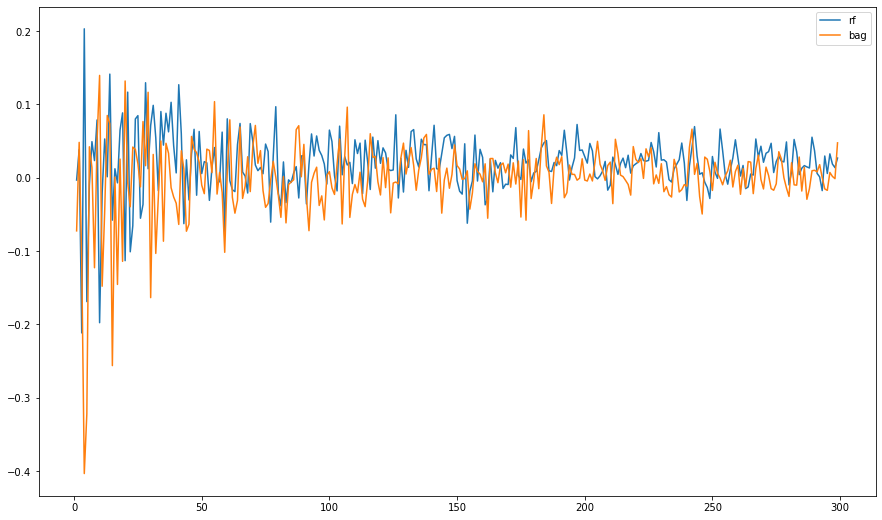

In [17]:
plt.rcParams["figure.figsize"] = (15,9)
plt.plot(test_error_rf, label='rf')
plt.plot(test_error_bag, label='bag')
plt.legend()
plt.show()

We can notice that the testing error doesn't increase when the number of tree increase. So that's why we said that the RF and bagging trees don't have overfitting problem. (<font color='brown'>Maybe yes, but not that obvious</font>)

## <font color='darkblue'>Implementing a "Not as random" forest</font>
([link](https://www.udemy.com/course/machine-learning-in-python-random-forest-adaboost/learn/lecture/6294918#questions))